# Stimulus Image Classifier

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

from src.dataset.kay import load_dataset
from src.utils.utils import prepare_data_arrays

from src.ml.test import test_model
from src.ml.train import train_model
from src.ml.dataset import StimulusDataset, calculate_mean_std
from src.ml.model import StimulusClassifier
from src.ml.utils import plot_loss_acc_curves, generate_score_report

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

title_size = 16
params = {'legend.fontsize': 14,
          'axes.labelsize': title_size - 2,
          'axes.titlesize': title_size,
          'xtick.labelsize': title_size - 4,
          'ytick.labelsize': title_size - 4,
          'axes.titlepad': 1.5 * title_size}

plt.rcParams.update(params)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


## Load Data

In [4]:
all_data = load_dataset(data_path="./../data/")

In [5]:
class_ignore_list = ["person", "fungus", "plant"]

In [6]:
x_trainval, y_trainval = prepare_data_arrays(all_data=all_data, 
                    data_subset="train", 
                    class_ignore_list=class_ignore_list, 
                    label_level=0)

x_train, x_val, y_train, y_val = train_test_split(x_trainval, 
                                                  y_trainval, 
                                                  test_size=0.2, 
                                                  stratify=y_trainval,
                                                  random_state=42)

x_test, y_test = prepare_data_arrays(all_data=all_data, 
                    data_subset="test", 
                    class_ignore_list=class_ignore_list, 
                    label_level=0)

In [7]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1393, 128, 128), (1393,), (349, 128, 128), (349,), (119, 128, 128), (119,))

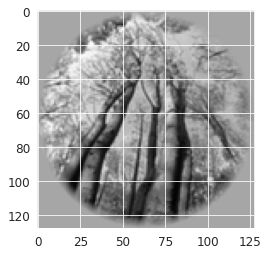

In [8]:
plt.imshow(x_train[0], cmap="gray")

In [9]:
class2idx = {k:i for i,k in enumerate(np.unique(y_trainval))}
idx2class = {v:k for k,v in class2idx.items()}

## Image Transforms

In [10]:
og_transform = A.Compose([
        A.Normalize(mean = (0, 0, 0), std  = (1, 1, 1)),
        ToTensorV2()
])

og_dataset = StimulusDataset(
        x_img=x_train, y_lbl=y_train, img_transform=og_transform, class2idx=class2idx
    )

In [11]:
dataset_mean, dataset_std = calculate_mean_std(dataset = og_dataset)

dataset_mean, dataset_std

  0%|          | 0/1393 [00:00<?, ?it/s]

(tensor([0.4599, 0.4599, 0.4599]), tensor([0.2172, 0.2172, 0.2172]))

In [12]:
img_transform = {
    "train": A.Compose([
        A.Normalize(mean = dataset_mean, std  = dataset_std),
        ToTensorV2()
    ]),
    "test": A.Compose([
        A.Normalize(mean = dataset_mean, std  = dataset_std),
        ToTensorV2()
    ])
}

## Create Dataset and Dataloader

In [13]:
train_dataset = StimulusDataset(x_img=x_train, 
                             y_lbl = y_train, 
                             img_transform = img_transform["train"], 
                             class2idx = class2idx)

val_dataset = StimulusDataset(x_img=x_val, 
                             y_lbl = y_val, 
                             img_transform = img_transform["test"], 
                             class2idx = class2idx)

test_dataset = StimulusDataset(x_img = x_test, 
                            y_lbl = y_test, 
                            img_transform = img_transform["test"], 
                            class2idx = class2idx)

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=8)

In [14]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 128, 128])

## Initialize Model

In [15]:
model = StimulusClassifier(num_channel=3, num_classes=len(class2idx))
model.to(device)

epochs = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99)

## Train Model

In [16]:
loss_stats, acc_stats = train_model(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 01/5: | Train Loss: 1.42611 | Val Loss: 1.33254 | Train Acc: 42.727% | Val Acc: 46.182%
Epoch 02/5: | Train Loss: 1.49120 | Val Loss: 1.71928 | Train Acc: 47.500% | Val Acc: 36.182%
Epoch 03/5: | Train Loss: 1.51296 | Val Loss: 1.61219 | Train Acc: 44.818% | Val Acc: 55.273%
Epoch 04/5: | Train Loss: 1.37850 | Val Loss: 1.50769 | Train Acc: 54.818% | Val Acc: 49.818%
Epoch 05/5: | Train Loss: 1.11996 | Val Loss: 1.49930 | Train Acc: 60.273% | Val Acc: 54.727%


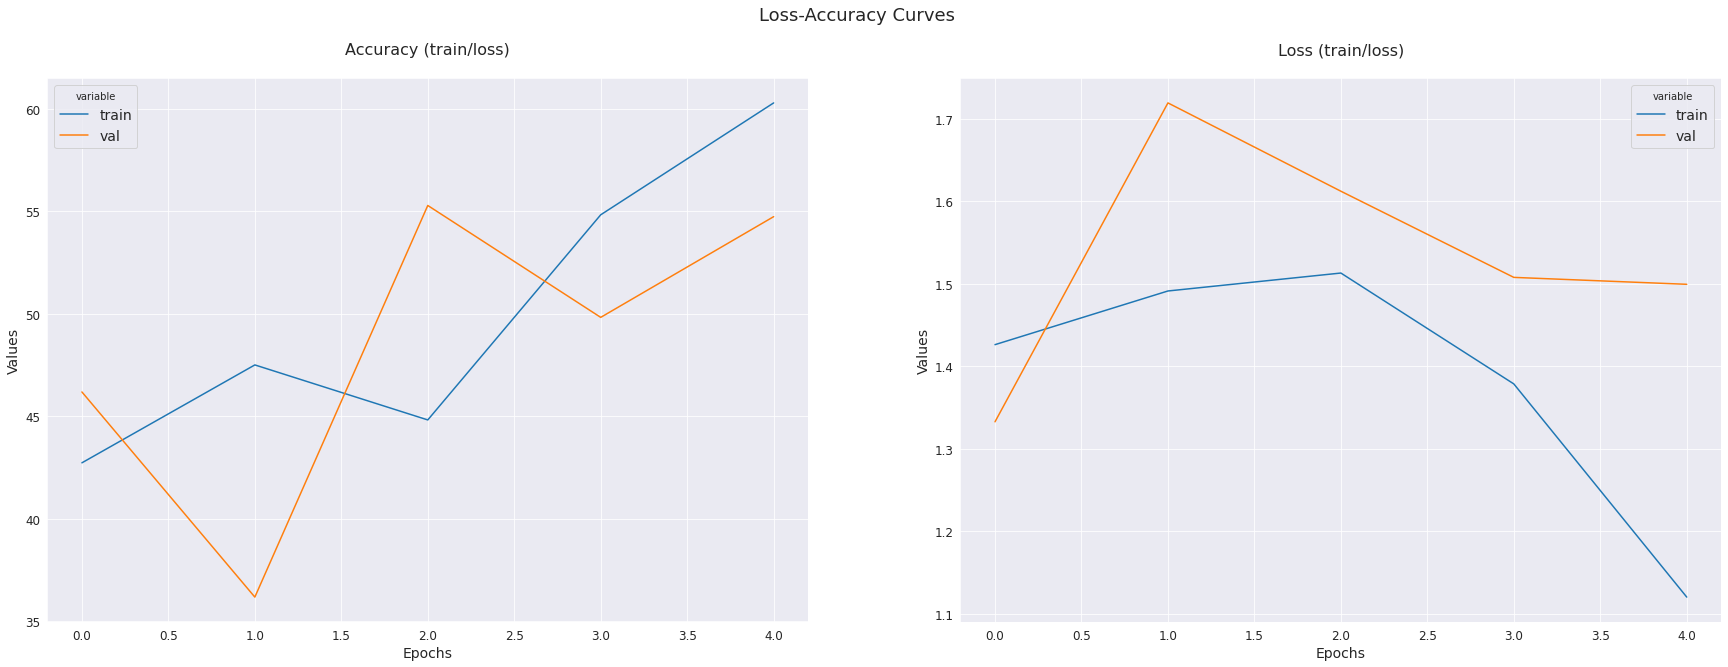

In [17]:
plot_loss_acc_curves(loss_stats, acc_stats)

## Test Model

In [18]:
y_true_list, y_pred_list = test_model(model, test_loader, device)

  0%|          | 0/15 [00:00<?, ?it/s]

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.43      0.50        54
           1       0.52      0.68      0.59        50
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10

    accuracy                           0.48       119
   macro avg       0.23      0.22      0.22       119
weighted avg       0.49      0.48      0.48       119






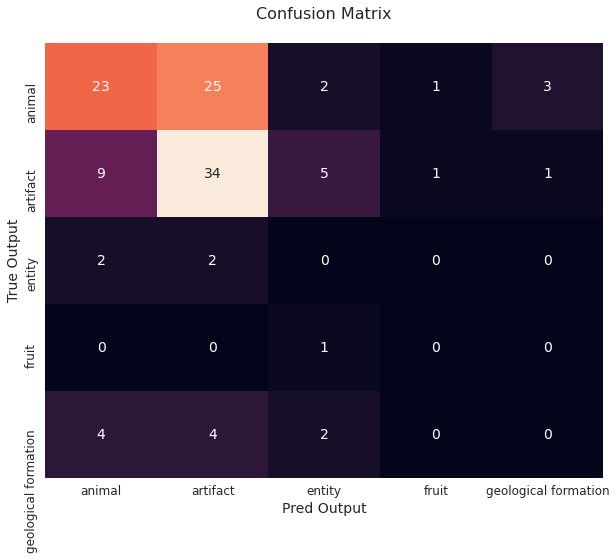

In [19]:
generate_score_report(y_true=y_true_list, y_pred=y_pred_list, idx2class=idx2class)